In [1]:
#| default_exp models.hint

# HINT

Hierarchical Forecast Networks (HINT) is a novel approach that combines SoTA neural forecast methods with flexible and efficient probability distributions and advanced hierarchical reconciliation strategies. This powerful combination allows HINT to produce accurate and coherent probabilistic predictions.

HINT's architecture incorporates a unique `TemporalNorm` module that leverages scaled-decoupled optimization. Additionally, it integrated bootstrapped sample filtering that enforces hierarchical constraints on the samples of its forecast distribution.

**References**<br>
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022)."Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". International Journal Forecasting, accepted paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)<br>
- [Kin G. Olivares, Federico Garza, David Luo, Cristian Challu, Max Mergenthaler, Souhaib Ben Taieb, Shanika Wickramasuriya, and Artur Dubrawski (2022). "HierarchicalForecast: A reference framework for hierarchical forecasting in python". Journal of Machine Learning Research, submitted, abs/2207.03517, 2022b.](https://arxiv.org/abs/2207.03517)

In [2]:
#| hide
from nbdev.showdoc import show_doc
from neuralforecast.losses.pytorch import GMM
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
import pandas as pd

In [3]:
#| export
from typing import Optional

import numpy as np
import torch

## 1. Reconciliation Methods

In [4]:
#| export
def get_bottomup_P(S: np.ndarray):
    """BottomUp Reconciliation Matrix.

    Creates BottomUp hierarchical \"projection\" matrix is defined as:
    $$\mathbf{P}_{\\text{BU}} = [\mathbf{0}_{\mathrm{[b],[a]}}\;|\;\mathbf{I}_{\mathrm{[b][b]}}]$$    

    **Parameters:**<br>
    `S`: Summing matrix of size (`base`, `bottom`).<br>

    **Returns:**<br>
    `P`: Reconciliation matrix of size (`bottom`, `base`).<br>

    **References:**<br>
    - [Orcutt, G.H., Watts, H.W., & Edwards, J.B.(1968). \"Data aggregation and information loss\". The American 
    Economic Review, 58 , 773{787)](http://www.jstor.org/stable/1815532).    
    """
    n_series = len(S)
    n_agg = n_series-S.shape[1]
    P = np.zeros_like(S)
    P[n_agg:,:] = S[n_agg:,:]
    P = P.T
    return P

def get_mintrace_ols_P(S: np.ndarray):
    """MinTraceOLS Reconciliation Matrix.

    Creates MinTraceOLS reconciliation matrix as proposed by Wickramasuriya et al.

    $$\mathbf{P}_{\\text{MinTraceOLS}}=\\left(\mathbf{S}^{\intercal}\mathbf{S}\\right)^{-1}\mathbf{S}^{\intercal}$$

    **Parameters:**<br>
    `S`: Summing matrix of size (`base`, `bottom`).<br>
      
    **Returns:**<br>
    `P`: Reconciliation matrix of size (`bottom`, `base`).<br>

    **References:**<br>
    - [Wickramasuriya, S.L., Turlach, B.A. & Hyndman, R.J. (2020). \"Optimal non-negative
    forecast reconciliation". Stat Comput 30, 1167–1182,
    https://doi.org/10.1007/s11222-020-09930-0](https://robjhyndman.com/publications/nnmint/).
    """
    n_hiers, n_bottom = S.shape
    n_agg = n_hiers - n_bottom

    W = np.eye(n_hiers)

    # We compute reconciliation matrix with
    # Equation 10 from https://robjhyndman.com/papers/MinT.pdf
    A = S[:n_agg,:]
    U = np.hstack((np.eye(n_agg), -A)).T
    J = np.hstack((np.zeros((n_bottom,n_agg)), np.eye(n_bottom)))
    P = J - (J @ W @ U) @ np.linalg.pinv(U.T @ W @ U) @ U.T
    return P

def get_mintrace_wls_P(S: np.ndarray):
    """MinTraceOLS Reconciliation Matrix.

    Creates MinTraceOLS reconciliation matrix as proposed by Wickramasuriya et al.
    Depending on a weighted GLS estimator and an estimator of the covariance matrix of the coherency errors $\mathbf{W}_{h}$.

    $$ \mathbf{W}_{h} = \mathrm{Diag}(\mathbf{S} \mathbb{1}_{[b]})$$

    $$\mathbf{P}_{\\text{MinTraceWLS}}=\\left(\mathbf{S}^{\intercal}\mathbf{W}_{h}\mathbf{S}\\right)^{-1}
    \mathbf{S}^{\intercal}\mathbf{W}^{-1}_{h}$$    

    **Parameters:**<br>
    `S`: Summing matrix of size (`base`, `bottom`).<br>
      
    **Returns:**<br>
    `P`: Reconciliation matrix of size (`bottom`, `base`).<br>

    **References:**<br>
    - [Wickramasuriya, S.L., Turlach, B.A. & Hyndman, R.J. (2020). \"Optimal non-negative
    forecast reconciliation". Stat Comput 30, 1167–1182,
    https://doi.org/10.1007/s11222-020-09930-0](https://robjhyndman.com/publications/nnmint/).
    """
    n_hiers, n_bottom = S.shape
    n_agg = n_hiers - n_bottom
    
    W = np.diag(S @ np.ones((n_bottom,)))

    # We compute reconciliation matrix with
    # Equation 10 from https://robjhyndman.com/papers/MinT.pdf
    A = S[:n_agg,:]
    U = np.hstack((np.eye(n_agg), -A)).T
    J = np.hstack((np.zeros((n_bottom,n_agg)), np.eye(n_bottom)))
    P = J - (J @ W @ U) @ np.linalg.pinv(U.T @ W @ U) @ U.T
    return P

In [5]:
show_doc(get_bottomup_P, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L13){target="_blank" style="float:right; font-size:smaller"}

### get_bottomup_P

>      get_bottomup_P (S:numpy.ndarray)

BottomUp Reconciliation Matrix.

Creates BottomUp hierarchical "projection" matrix is defined as:
$$\mathbf{P}_{\text{BU}} = [\mathbf{0}_{\mathrm{[b],[a]}}\;|\;\mathbf{I}_{\mathrm{[b][b]}}]$$    

**Parameters:**<br>
`S`: Summing matrix of size (`base`, `bottom`).<br>

**Returns:**<br>
`P`: Reconciliation matrix of size (`bottom`, `base`).<br>

**References:**<br>
- [Orcutt, G.H., Watts, H.W., & Edwards, J.B.(1968). "Data aggregation and information loss". The American 
Economic Review, 58 , 773{787)](http://www.jstor.org/stable/1815532).

In [6]:
show_doc(get_mintrace_ols_P, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L37){target="_blank" style="float:right; font-size:smaller"}

### get_mintrace_ols_P

>      get_mintrace_ols_P (S:numpy.ndarray)

MinTraceOLS Reconciliation Matrix.

Creates MinTraceOLS reconciliation matrix as proposed by Wickramasuriya et al.

$$\mathbf{P}_{\text{MinTraceOLS}}=\left(\mathbf{S}^{\intercal}\mathbf{S}\right)^{-1}\mathbf{S}^{\intercal}$$

**Parameters:**<br>
`S`: Summing matrix of size (`base`, `bottom`).<br>

**Returns:**<br>
`P`: Reconciliation matrix of size (`bottom`, `base`).<br>

**References:**<br>
- [Wickramasuriya, S.L., Turlach, B.A. & Hyndman, R.J. (2020). "Optimal non-negative
forecast reconciliation". Stat Comput 30, 1167–1182,
https://doi.org/10.1007/s11222-020-09930-0](https://robjhyndman.com/publications/nnmint/).

In [7]:
show_doc(get_mintrace_wls_P, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L69){target="_blank" style="float:right; font-size:smaller"}

### get_mintrace_wls_P

>      get_mintrace_wls_P (S:numpy.ndarray)

MinTraceOLS Reconciliation Matrix.

Creates MinTraceOLS reconciliation matrix as proposed by Wickramasuriya et al.
Depending on a weighted GLS estimator and an estimator of the covariance matrix of the coherency errors $\mathbf{W}_{h}$.

$$ \mathbf{W}_{h} = \mathrm{Diag}(\mathbf{S} \mathbb{1}_{[b]})$$

$$\mathbf{P}_{\text{MinTraceWLS}}=\left(\mathbf{S}^{\intercal}\mathbf{W}_{h}\mathbf{S}\right)^{-1}
\mathbf{S}^{\intercal}\mathbf{W}^{-1}_{h}$$    

**Parameters:**<br>
`S`: Summing matrix of size (`base`, `bottom`).<br>

**Returns:**<br>
`P`: Reconciliation matrix of size (`bottom`, `base`).<br>

**References:**<br>
- [Wickramasuriya, S.L., Turlach, B.A. & Hyndman, R.J. (2020). "Optimal non-negative
forecast reconciliation". Stat Comput 30, 1167–1182,
https://doi.org/10.1007/s11222-020-09930-0](https://robjhyndman.com/publications/nnmint/).

## 2. HINT

In [8]:
#| export
class HINT:
    """ HINT

    The Hierarchical Forecast Network (HINT) combines SoTA neural forecast methods with
    flexible and efficient probability distributions and advanced hierarchical reconciliation strategies.
    This powerful combination allows HINT to produce accurate and coherent probabilistic predictions.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `model`: NeuralForecast model, instantiated train loss class from [models collection](https://nixtla.github.io/neuralforecast/models.pytorch.html).<br>
    `S`: np.ndarray, dumming matrix of size (`base`, `bottom`) see [aggregate method](https://nixtla.github.io/hierarchicalforecast/utils.html#aggregate).<br>
    `reconciliation`: str, HINT's reconciliation method from ['BottomUp', 'MinTraceOLS', 'MinTraceWLS'].<br>
    `alias`: str, optional,  Custom name of the model.<br>
    """
    def __init__(self,
                 h: int,
                 S: np.ndarray,
                 model,
                 reconciliation: str,
                 alias: Optional[str] = None):
        
        if model.h != h:
            raise Exception(f"Model h {model.h} does not match HINT h {h}")
        
        if not model.loss.is_distribution_output:
            raise Exception(f"The NeuralForecast model's loss {model.loss} is not a probabilistic objective")
        
        self.h = h
        self.model = model
        self.S = S
        self.reconciliation = reconciliation
        self.loss = model.loss

        available_reconciliations = dict(
                                BottomUp=get_bottomup_P,
                                MinTraceOLS=get_mintrace_ols_P,
                                MinTraceWLS=get_mintrace_wls_P   
                                )

        if reconciliation not in available_reconciliations:
            raise Exception(f"Reconciliation {reconciliation} not available")

        # Get SP matrix
        P = available_reconciliations[reconciliation](S=S)
        self.SP = S @ P

        qs = torch.Tensor((np.arange(self.loss.num_samples)/self.loss.num_samples))
        self.sample_quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.alias = alias
    
    def __repr__(self):
        return type(self).__name__ if self.alias is None else self.alias


    def fit(self, dataset, val_size=0, test_size=0, random_seed=None):
        """ HINT.fit

        HINT trains on the entire hierarchical dataset, by minimizing a composite log likelihood or likelihoood objective.
        HINT's architecture integrates `TemporalNorm` for a scale-decoupled optimization that robustifies cross-learning 
        the hierachy's series scales.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `val_size`: int, size of the validation set, (default 0).<br>
        `test_size`: int, size of the test set, (default 0).<br>
        `random_seed`: int, random seed for the prediction.<br>

        **Returns:**<br>
        `self`: A fitted base `NeuralForecast` model.<br>
        """
        self.model.fit(dataset=dataset,
                       val_size=val_size,
                       test_size=test_size,
                       random_seed=random_seed)

    def predict(self, dataset, step_size=1, random_seed=None, **data_module_kwargs):
        """ HINT.predict

        After fitting a base model on the entire hierarchical dataset.
        HINT ensures hierarchical constraints using bootstrapped sample reconciliation 
        First sampling from its base forecast distribution.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `step_size`: int, steps between sequential predictions, (default 1).<br>
        `random_seed`: int, random seed for the prediction.<br>
        `**data_kwarg`: additional parameters for the dataset module.<br>

        **Returns:**<br>
        `y_hat`: numpy predictions of the `NeuralForecast` model.<br>
        """
        num_samples = self.model.loss.num_samples

        # Hack to get samples by simulating quantiles (samples will be ordered)
        # Mysterious parsing associated to default [mean,quantiles] output
        quantiles_old = self.model.loss.quantiles
        names_old = self.model.loss.output_names
        self.model.loss.quantiles = self.sample_quantiles
        self.model.loss.output_names = ['1'] * (1 + num_samples)
        samples = self.model.predict(dataset=dataset, 
                                     step_size=step_size,
                                     random_seed=random_seed,
                                     **data_module_kwargs)
        samples = samples[:,1:] # Eliminate mean from quantiles
        self.model.loss.quantiles = quantiles_old
        self.model.loss.output_names = names_old

        # Hack requires to break quantiles correlations between samples
        idxs = np.random.choice(num_samples, size=samples.shape, replace=True)
        aux_col_idx = np.arange(len(samples))[:,None] * num_samples
        idxs = idxs + aux_col_idx
        samples = samples.flatten()[idxs]
        samples = samples.reshape(dataset.n_groups, -1, self.h, num_samples)
        
        # Bootstrap Sample Reconciliation
        # Default output [mean, quantiles]
        samples = np.einsum('ij,jwhp->iwhp', self.SP, samples)
        forecasts = np.quantile(samples, self.model.loss.quantiles, axis=-1)
        forecasts = forecasts.transpose(1,2,3,0) # [...,samples]
        forecasts = forecasts.reshape(-1, len(self.model.loss.quantiles))
        
        sample_mean = np.mean(forecasts, axis=-1, keepdims=True)
        forecasts = np.concatenate([sample_mean, forecasts], axis=-1)
        return forecasts

    def set_test_size(self, test_size):
        self.model.test_size = test_size

    def save(self, path):
        """ HINT.save

        Save the HINT fitted model to disk.

        **Parameters:**<br>
        `path`: str, path to save the model.<br>
        """
        self.model.trainer.save_checkpoint(path)

In [9]:
show_doc(HINT.__init__, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L120){target="_blank" style="float:right; font-size:smaller"}

### HINT.__init__

>      HINT.__init__ (h:int, S:numpy.ndarray, model, reconciliation:str,
>                     alias:Union[str,NoneType]=None)

Initialize self.  See help(type(self)) for accurate signature.

In [10]:
show_doc(HINT.fit, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L162){target="_blank" style="float:right; font-size:smaller"}

### HINT.fit

>      HINT.fit (dataset, val_size=0, test_size=0, random_seed=None)

HINT.fit

HINT trains on the entire hierarchical dataset, by minimizing a composite log likelihood or likelihoood objective.
HINT's architecture integrates `TemporalNorm` for a scale-decoupled optimization that robustifies cross-learning 
the hierachy's series scales.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`val_size`: int, size of the validation set, (default 0).<br>
`test_size`: int, size of the test set, (default 0).<br>
`random_seed`: int, random seed for the prediction.<br>

**Returns:**<br>
`self`: A fitted base `NeuralForecast` model.<br>

In [11]:
show_doc(HINT.predict, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L185){target="_blank" style="float:right; font-size:smaller"}

### HINT.predict

>      HINT.predict (dataset, step_size=1, random_seed=None,
>                    **data_module_kwargs)

HINT.predict

After fitting a base model on the entire hierarchical dataset.
HINT ensures hierarchical constraints using bootstrapped sample reconciliation 
First sampling from its base forecast distribution.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`step_size`: int, steps between sequential predictions, (default 1).<br>
`random_seed`: int, random seed for the prediction.<br>
`**data_kwarg`: additional parameters for the dataset module.<br>

**Returns:**<br>
`y_hat`: numpy predictions of the `NeuralForecast` model.<br>

In [12]:
show_doc(HINT.save, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/hint.py#L236){target="_blank" style="float:right; font-size:smaller"}

### HINT.save

>      HINT.save (path)

HINT.save

Save the HINT fitted model to disk.

**Parameters:**<br>
`path`: str, path to save the model.<br>

In [13]:
# | hide
def sort_df_hier(Y_df, S):
    # NeuralForecast core, sorts unique_id lexicographically
    # by default, this class matches S_df and Y_hat_df order.    
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

In [14]:
#| eval: false
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, PMM, NBMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

from datasetsforecast.hierarchical import HierarchicalData

# Load TourismSmall dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismSmall')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df = sort_df_hier(Y_df, S_df)

# Instantiate HINT
# Model + Distribution + Reconciliation
nhits = NHITS(h=4,
              input_size=12,
              loss=GMM(n_components=2, level=[80,90]),
              max_steps=1000,
              early_stop_patience_steps=2,
              val_check_steps=100,
              scaler_type='robust',
              learning_rate=1e-3)
model = HINT(h=4, model=nhits, S=S_df.values, reconciliation='MinTraceOLS')

# Fit and Predict
nf = NeuralForecast(models=[model], freq='Q')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=4, n_windows=1)

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 63.99it/s]


[]

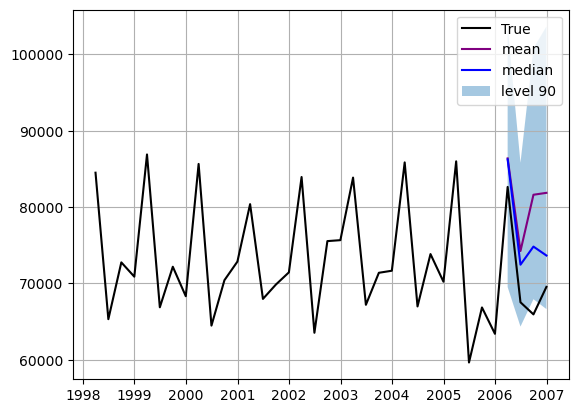

In [15]:
#| eval: false
# Plot coherent quantile predictions
unique_id = 'total'
Y_plot_df = Y_df[Y_df.unique_id==unique_id]
plot_df = Y_hat_df[Y_hat_df.unique_id==unique_id]
plot_df = Y_plot_df.merge(plot_df, on=['ds', 'unique_id'], how='left')

plt.plot(plot_df['ds'], plot_df['y_x'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['HINT'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-4:],
                 y1=plot_df['HINT-lo-90'][-4:].values,
                 y2=plot_df['HINT-hi-90'][-4:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [16]:
# | hide
# Unit test to check hierarchical coherence
# Probabilistic coherent => Sample coherent => Mean coherence

# -----Create synthetic dataset-----
np.random.seed(123)
train_steps = 20
num_levels = 7
level = np.arange(0, 100, 0.1)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

levels = ['Top', 'Mid1', 'Mid2', 'Bottom1', 'Bottom2', 'Bottom3', 'Bottom4']
unique_ids = np.repeat(levels, train_steps)

S = np.array([[1., 1., 1., 1.],
              [1., 1., 0., 0.],
              [0., 0., 1., 1.],
              [1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

S_dict = {col: S[:, i] for i, col in enumerate(levels[3:])}
S_df = pd.DataFrame(S_dict, index=levels)

ds = pd.date_range(start='2018-03-31', periods=train_steps, freq='Q').tolist() * num_levels
# Create Y_df
y_lists = [S @ np.random.uniform(low=100, high=500, size=4) for i in range(train_steps)]
y = [elem for tup in zip(*y_lists) for elem in tup]
Y_df = pd.DataFrame({'unique_id': unique_ids, 'ds': ds, 'y': y})
Y_df = sort_df_hier(Y_df, S_df)

# ------Fit/Predict HINT Model------
# Model + Distribution + Reconciliation
nhits = NHITS(h=4,
              input_size=4,
              loss=GMM(n_components=2, quantiles=quantiles, num_samples=len(quantiles)),
              max_steps=5,
              early_stop_patience_steps=2,
              val_check_steps=1,
              scaler_type='robust',
              learning_rate=1e-3)
model = HINT(h=4, model=nhits, S=S, reconciliation='BottomUp')

# Fit and Predict
nf = NeuralForecast(models=[model], freq='Q')
forecasts = nf.cross_validation(df=Y_df, val_size=4, n_windows=1)

# ---Check Hierarchical Coherence---
parent_children_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6]}
eps = 0.03
# check coherence for each horizon time step
for _, df in forecasts.groupby('ds'):
    hint_mean = df['HINT'].values
    for parent_idx, children_list in parent_children_dict.items():
        parent_value = hint_mean[parent_idx]
        children_sum = hint_mean[children_list].sum()
        percent_diff = np.round(abs(parent_value-children_sum)/parent_value * 100, 2)
        print(f"Percentage Difference: {percent_diff}")
        assert percent_diff < eps

Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.91it/s]
Percentage Difference: 0.01
Percentage Difference: 0.01
Percentage Difference: 0.0
Percentage Difference: 0.0
Percentage Difference: 0.0
Percentage Difference: 0.02
Percentage Difference: 0.01
Percentage Difference: 0.0
Percentage Difference: 0.0
Percentage Difference: 0.0
Percentage Difference: 0.0
Percentage Difference: 0.01
